In [1]:
# Cargar el DataFrame desde el archivo Parquet utilizando Dask
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import gc

# Cargar datos
data_dd = dd.read_parquet(r'C:\Users\HOME\OneDrive - Universidad Nacional de Colombia\maestria_big_data\clases\TFM\codigo_TFM\data.parquet', engine='pyarrow')

# Separar las características y la etiqueta
X = data_dd['susceptibilidad'].compute().values.reshape(-1, 1)
y = data_dd['inventario'].compute()

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Liberar memoria
gc.collect()


53

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Definir los parámetros para la búsqueda
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Número de árboles
    'max_depth': [None, 10, 20, 30, 50],   # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],       # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],         # Mínimo número de muestras en un nodo hoja
    'max_features': ['auto', 'sqrt', 'log2'],  # Máximo número de características a considerar
    'bootstrap': [True, False],            # Si se usa bootstrap al construir los árboles
    'class_weight': [
        'balanced', 
        {0: 1, 1: 1},  # Pesos iguales para ambas clases
        {0: 1, 1: 2},  # Clase minoritaria con el doble de peso
        {0: 1, 1: 5},  # Peso más alto para la clase minoritaria
        {0: 1, 1: 10}, 
        {0: 1, 1: 15}, 
        {0: 1, 1: 20}, 
        {0: 1, 1: 50}, 
        {0: 1, 1: 100}, # Aumentando progresivamente para evaluar el impacto en clases muy desbalanceadas
        {0: 1, 1: 200}
    ]  # Rango ampliado para los pesos de la clase minoritaria
}

# Crear el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=100,  # Número de combinaciones a probar
    scoring='roc_auc',  # Optimizar para el AUC-ROC
    cv=3,  # Validación cruzada con 3 divisiones
    verbose=2,
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': {0: 1, 1: 1}, 'bootstrap': False}


In [3]:
# Ejecutar la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'class_weight': {0: 1, 1: 1}, 'bootstrap': False}


In [4]:
# Entrenar el modelo con los mejores hiperparámetros
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 1}, max_depth=50,
                       min_samples_leaf=2, random_state=42)

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Evaluar el modelo en el conjunto de validación
y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation ROC AUC: {val_roc_auc}')
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.6790343074968234
Validation ROC AUC: 0.5067658223039815
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80      2928
         1.0       0.27      0.15      0.19      1007

    accuracy                           0.68      3935
   macro avg       0.51      0.50      0.49      3935
weighted avg       0.62      0.68      0.64      3935



In [6]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test ROC AUC: {test_roc_auc}')
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.6821646341463414
Test ROC AUC: 0.48820948270955256
              precision    recall  f1-score   support

         0.0       0.75      0.87      0.80      2955
         1.0       0.23      0.12      0.16       981

    accuracy                           0.68      3936
   macro avg       0.49      0.49      0.48      3936
weighted avg       0.62      0.68      0.64      3936



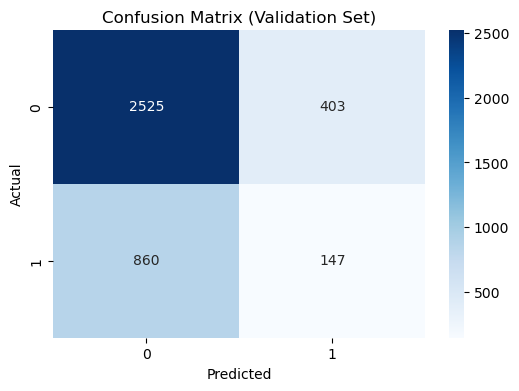

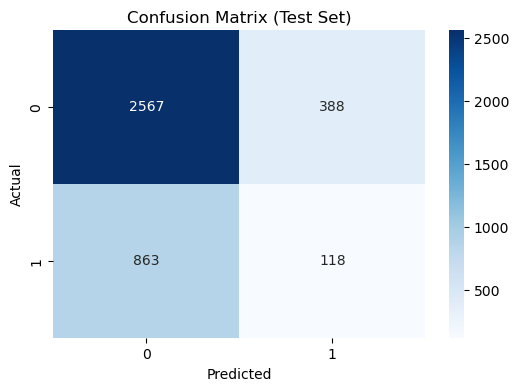

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión para el conjunto de validación
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
